In [1]:
import torch
import pandas as pd
import pickle
import numpy as np
from scipy import stats
from collections import defaultdict
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
# read in the data
with open("../../data/qualitative_data/all_scores_by_model.p", "rb") as fp:
    all_model_scores = pickle.load(fp)

with open("../../data/qualitative_data/all_exo_by_model.p", "rb") as fp:
    all_model_exo = pickle.load(fp)
    
for agent_type in all_model_exo:
    all_model_exo[agent_type] = [torch.tensor(x, dtype=torch.float64) for x in all_model_exo[agent_type]]
    
with open("../../data/qualitative_data/all_lqr_scores.p", "rb") as fp:
    lqr_scores = pickle.load(fp)

with open("../../data/qualitative_data/all_lqr_exo.p", "rb") as fp:
    lqr_exo = pickle.load(fp)
    
results_folder = "../../figures/"
all_model_scores['lqr'] = lqr_scores
all_model_exo['lqr'] = lqr_exo

In [3]:
len(all_model_scores["sparse_max_continuous"]) / 14

300.0

In [4]:
# print all the median model scores
for model in all_model_scores:
    med = np.median(all_model_scores[model])
    iqr = stats.iqr(all_model_scores[model])
    print(f"{model}: {np.round(med,1)} ({np.round(iqr,1)})")

null_model_2: 535.4 (542.1)
hill_climbing: 146.5 (135.1)
sparse_max_discrete: 121.9 (106.2)
sparse_max_continuous: 275.0 (270.4)
sparse_lqr: 107.7 (129.3)
null_model_1: 425.3 (454.8)
lqr: 6.4 (3.6)


In [5]:
# compute the norm standard deviation and number of variables into a dictionary for each model
all_model_n_var = defaultdict(list)
all_model_norm_std = defaultdict(list)
for model in all_model_exo:
    for action in all_model_exo[model]:
        all_model_n_var[model].append(len([x for x in action if x != 0]))
    
    for i in range(0,len(all_model_exo[model]), 10):
        run = all_model_exo[model][i:i+10]
        all_model_norm_std[model].append(np.std([np.linalg.norm(x) for x in run]))

In [6]:
# print the medians and interquartile ranges for number of variables manipulated
for model in all_model_n_var:
    med = np.median(all_model_n_var[model])
    iqr = stats.iqr(all_model_n_var[model])
    print(f"{model}: {med} ({iqr})")

null_model_2: 0.0 (0.0)
hill_climbing: 4.0 (0.0)
sparse_max_discrete: 1.0 (1.0)
sparse_max_continuous: 1.0 (2.0)
sparse_lqr: 1.0 (2.0)
null_model_1: 2.0 (2.0)
lqr: 4.0 (0.0)


In [7]:
# print the medians and interquartile ranges for the standard deviation of input norms
for model in all_model_norm_std:
    med = np.median(all_model_norm_std[model])
    iqr = stats.iqr(all_model_norm_std[model])
    print(f"{model}: {np.round(med,2)} ({np.round(iqr,2)})")

null_model_2: 0.0 (0.0)
hill_climbing: 1.95 (2.64)
sparse_max_discrete: 12.95 (12.16)
sparse_max_continuous: 13.37 (29.45)
sparse_lqr: 15.5 (34.87)
null_model_1: 0.98 (0.49)
lqr: 1.23 (0.8)


Read the human data to compute statistics involving human performance

In [8]:
pp_data_file = '../../data/experimental_data/experiment_actions.csv'
n_pps = 111

In [9]:
# read the participant data
df_human = pd.read_csv(pp_data_file)
df_pps = df_human.loc[df_human.groupby('pp_id')['id'].idxmax()]
df_pps['root_cost'] = df_pps['total_cost'].apply(np.sqrt)  # compute the root human costs

In [10]:
# test lqr vs human scores
stats.kruskal(all_model_scores['lqr'], df_pps['root_cost'])

KruskalResult(statistic=67.59101636848118, pvalue=2.0118215502595996e-16)

Plot histograms of model performances and qualitative measures

In [11]:
# number of participants excluded from the histogram
len(df_pps[df_pps["root_cost"] > 500])

6

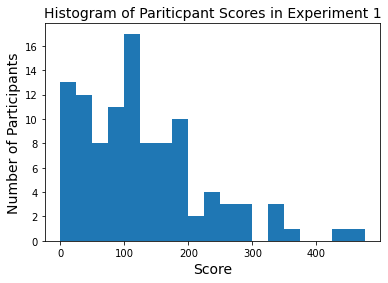

In [12]:
# Plot the human scores
plt.hist(df_pps[df_pps['root_cost'] <= 500]['root_cost'], bins=np.arange(0,500,25))
plt.title("Histogram of Pariticpant Scores in Experiment 1", fontsize=14)
plt.ylabel("Number of Participants", fontsize=14)
plt.xlabel("Score", fontsize=14)
plt.savefig("../../figures/human_scores.pdf")

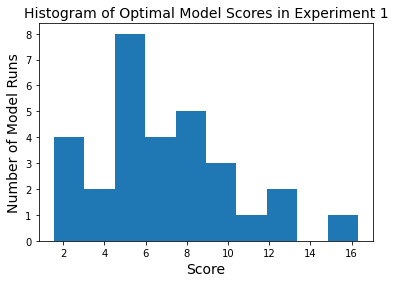

In [13]:
# Plot the LQR scores with a scale appropriate for the scores it achieves
plt.hist(all_model_scores['lqr'][:30])
plt.title("Histogram of Optimal Model Scores in Experiment 1", fontsize=14)
plt.ylabel("Number of Model Runs", fontsize=14)
plt.xlabel("Score", fontsize=14)
plt.savefig("../../figures/lqr_scores_newscale.pdf")

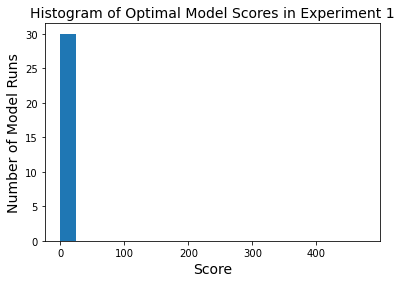

In [14]:
# Plot the LQR scores with the same scale as the human performance plot
plt.hist(all_model_scores['lqr'][:30], bins=np.arange(0,500,25))
plt.title("Histogram of Optimal Model Scores in Experiment 1", fontsize=14)
plt.ylabel("Number of Model Runs", fontsize=14)
plt.xlabel("Score", fontsize=14)
plt.savefig("../../figures/lqr_scores_samescale.pdf")

Plot the standard deviation of input norms for each model type

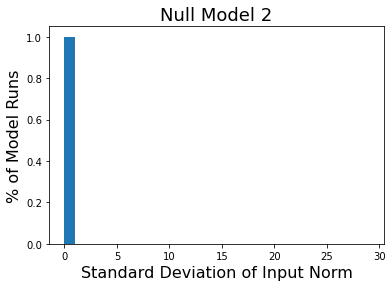

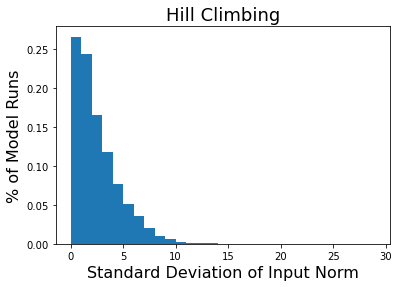

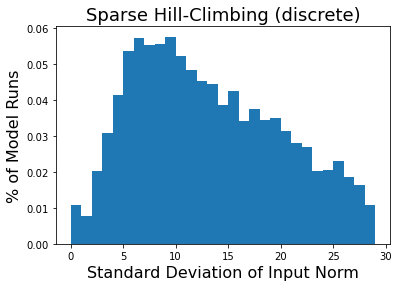

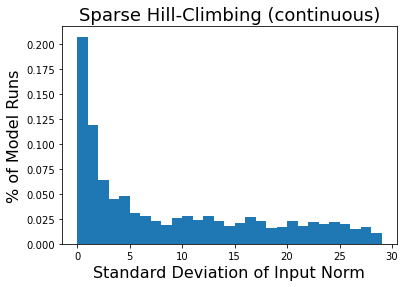

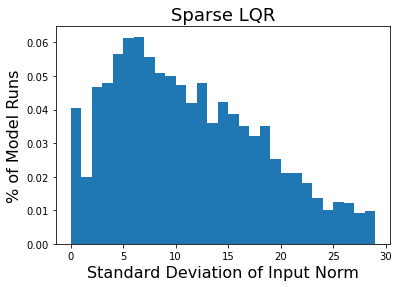

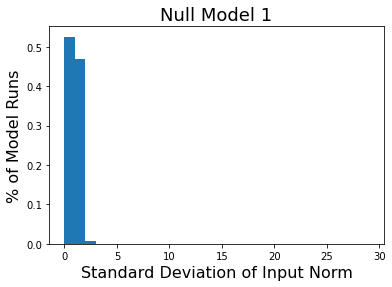

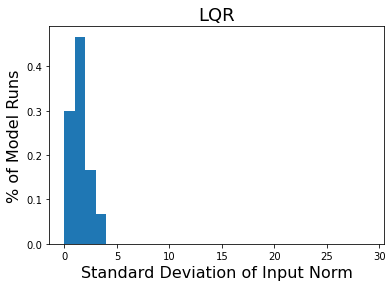

In [15]:
model_names = {"null_model_2": "Null Model 2", "null_model_1": "Null Model 1", "sparse_lqr": "Sparse LQR", "sparse_max_discrete": "Sparse Hill-Climbing (discrete)", "sparse_max_continuous": "Sparse Hill-Climbing (continuous)", "hill_climbing": "Hill Climbing", "lqr": "LQR"}

# Plot (and save) the input norm standard deviations for all models
all_model_input_norm_stds = {}
for model_type in all_model_exo.keys():
    input_norm_stds = []
    
    for i in range(0,len(all_model_exo[model_type]),10):
        run = all_model_exo[model_type][i:i+10]
        input_norm_stds.append(np.std([np.linalg.norm(x) for x in run]))
        all_model_input_norm_stds[model_type] = input_norm_stds
        
    bins = np.arange(0,30,1)
    plt.hist(input_norm_stds, bins, density=True)
    plt.title(f"{model_names[model_type]}", fontsize=18)
    plt.xlabel("Standard Deviation of Input Norm", fontsize=16)
    plt.ylabel("% of Model Runs", fontsize=16)
    plt.savefig(results_folder + f"input_norms_{model_type}.pdf")
    plt.show()

Plot the number of variables manipulated for each model type

null_model_2


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


hill_climbing


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_max_discrete


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_max_continuous


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


sparse_lqr


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


null_model_1


<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-16-be984375006f>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


lqr


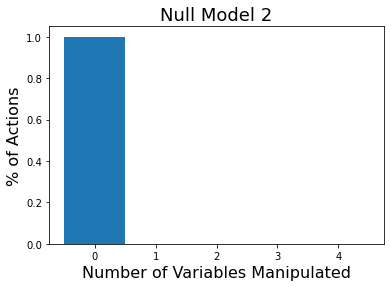

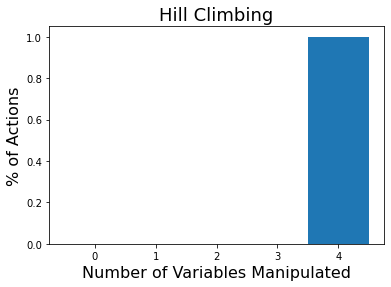

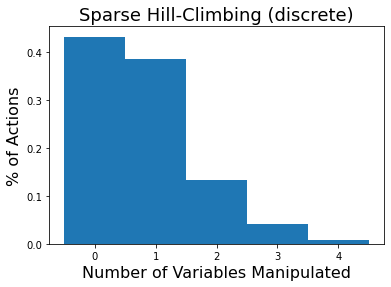

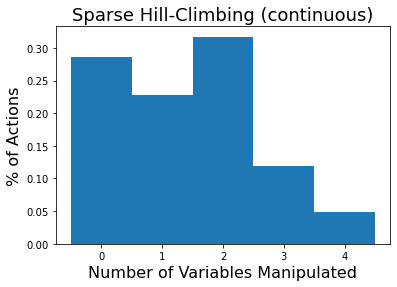

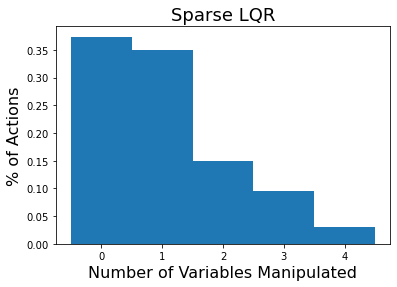

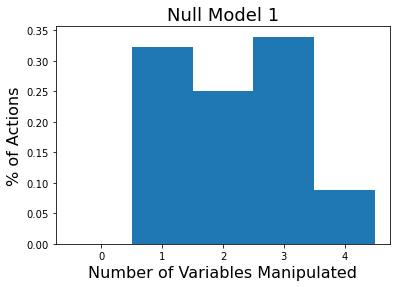

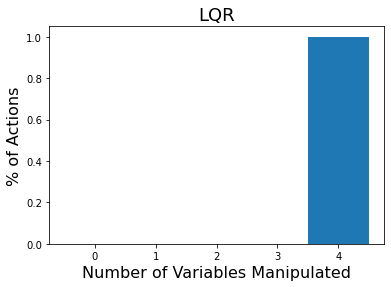

In [16]:
# Plot the number of variables manipulated for all models 
for model_type in all_model_exo.keys():
    print(model_type)
    all_n_var = []
    for exo in all_model_exo[model_type]:
        all_n_var.append(len([x for x in exo if x != 0]))
    
    bins = np.arange(0,6,1)
    fig, ax = plt.subplots()
    ax.hist(all_n_var, bins, density=True)
    ax.set_title(f"{model_names[model_type]}", fontsize=18)
    ax.set_xlabel("Number of Variables Manipulated", fontsize=16)
    ax.set_ylabel("% of Actions", fontsize=16)
    ax.set_xticks(np.arange(0.5, 5.5, 1))
    ax.set_xticklabels(range(5))
    fig.savefig(results_folder + f"n_vars_{model_type}.pdf")
    fig.show()

In [17]:
# compute all the exogenous variables, input norms, and number of variables manipulated
all_human_exo = [literal_eval(x) for x in df_human['exogenous_input']]
all_human_norms = [np.linalg.norm(exo) for exo in all_human_exo]
all_human_n_var = [len([x for x in exo if x == 0]) for exo in all_human_exo]

Plot the standard deviation of input norm and number of variables manipulated for humans

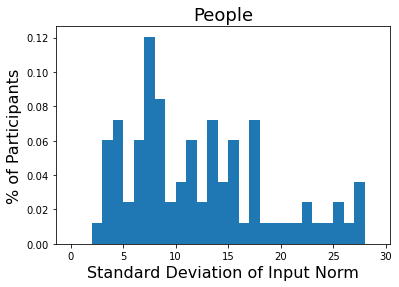

In [18]:
# compute the input norm standard deviations for humans
human_input_norm_stds = []
for pp in df_human['pp_id'].drop_duplicates():
    df_pp = df_human[df_human['pp_id'] == pp]
    run = df_pp['exogenous_input']
    human_input_norm_stds.append(np.std([np.linalg.norm(literal_eval(x)) for x in run]))

# plot the input norm standard deviations
bins = np.arange(0,30,1)
plt.hist(human_input_norm_stds, bins, density=True)
plt.title(f"People", fontsize=18)
plt.xlabel("Standard Deviation of Input Norm", fontsize=16)
plt.ylabel("% of Participants", fontsize=16)
plt.savefig(results_folder + f"input_norms_human.pdf")
plt.show()

<ipython-input-19-5a998e1a83f4>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


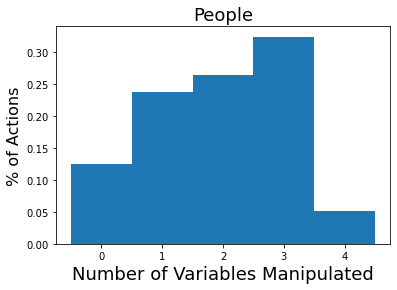

In [19]:
# plot the number of variables manipulated by humans
bins = np.arange(0,6,1)
fig, ax = plt.subplots()
ax.hist(all_human_n_var, bins, density=True)
ax.set_title(f"People", fontsize=18)
ax.set_xlabel("Number of Variables Manipulated", fontsize=18)
ax.set_ylabel("% of Actions", fontsize=16)
ax.set_xticks(np.arange(0.5, 5.5, 1))
ax.set_xticklabels(range(5))
fig.savefig(results_folder + f"n_vars_human.pdf")
fig.show()

Run the statistical tests

In [20]:
for model in all_model_n_var:
    print(f"humans vs {model}: {np.median(all_human_n_var)} vs. {np.median(all_model_n_var[model])} {stats.kruskal(all_human_n_var, all_model_n_var[model])}")

humans vs null_model_2: 2.0 vs. 0.0 KruskalResult(statistic=42823.745251405126, pvalue=0.0)
humans vs hill_climbing: 2.0 vs. 4.0 KruskalResult(statistic=106390.41565124452, pvalue=0.0)
humans vs sparse_max_discrete: 2.0 vs. 1.0 KruskalResult(statistic=1137.4326270937486, pvalue=2.4167932231069616e-249)
humans vs sparse_max_continuous: 2.0 vs. 1.0 KruskalResult(statistic=228.99463381569964, pvalue=9.876389938929584e-52)
humans vs sparse_lqr: 2.0 vs. 1.0 KruskalResult(statistic=642.7761803724363, pvalue=8.320760286217135e-142)
humans vs null_model_1: 2.0 vs. 2.0 KruskalResult(statistic=43.07123105956753, pvalue=5.278271373864621e-11)
humans vs lqr: 2.0 vs. 4.0 KruskalResult(statistic=671.0939320967237, pvalue=5.7770733331058734e-148)


In [21]:
for model in all_model_input_norm_stds:
    print(f"humans vs {model}: {np.median(human_input_norm_stds)} vs. {np.median(all_model_input_norm_stds[model])} {stats.kruskal(human_input_norm_stds, all_model_input_norm_stds[model])}")

humans vs null_model_2: 14.681139904908841 vs. 0.0 KruskalResult(statistic=4909.144767648331, pvalue=0.0)
humans vs hill_climbing: 14.681139904908841 vs. 1.9539280176421316 KruskalResult(statistic=287.72997902261704, pvalue=1.5530303166374404e-64)
humans vs sparse_max_discrete: 14.681139904908841 vs. 12.949011985882613 KruskalResult(statistic=5.582741199589446, pvalue=0.018138310705375745)
humans vs sparse_max_continuous: 14.681139904908841 vs. 13.368228380136149 KruskalResult(statistic=4.815410722730061, pvalue=0.02820634902541099)
humans vs sparse_lqr: 14.681139904908841 vs. 15.500431616677227 KruskalResult(statistic=1.0007339112124072, pvalue=0.3171329879770311)
humans vs null_model_1: 14.681139904908841 vs. 0.981696910760723 KruskalResult(statistic=321.01542416452503, pvalue=8.704041469265421e-72)
humans vs lqr: 14.681139904908841 vs. 1.2320062920796198 KruskalResult(statistic=69.25780992259865, pvalue=8.639813260082065e-17)
